<a href="https://colab.research.google.com/github/AhmedAboulezz/Trading/blob/main/Divergence_Cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
# Install required packages
!pip install pandas numpy matplotlib plotly scipy ta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.signal import argrelextrema
import ta
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

#------------------------------------------------------------------------------
# CONFIGURATION PARAMETERS
#------------------------------------------------------------------------------

class Config:
    # Pivot settings
    prd = 5  # Pivot Period
    source = "Close"  # Source for Pivot Points: "Close" or "High/Low"

    # Divergence settings
    searchdiv = "Regular"  # "Regular", "Hidden", or "Regular/Hidden"
    showlimit = 1  # Minimum Number of Divergence (any)
    maxpp = 10  # Maximum Pivot Points to Check
    maxbars = 100  # Maximum Bars to Check
    dontconfirm = False  # Don't Wait for Confirmation

    # Quality filter
    minPosDivForEntry = 2  # Min # of Positive Divergence for Valid Long
    minNegDivForExit = 1   # Min # of Negative Divergence for Exit

    # Entry delay and drawdown
    delayBars = 0  # Delay For Entry (Bars)
    useDrawdown = False  # Use % Drawdown Before Entry
    drawdownPerc = 1.0  # Drawdown %

    # Indicator selection (all enabled by default)
    calcmacd = True
    calcmacda = True
    calcrsi = True
    calcstoc = True
    calccci = True
    calcmom = True
    calcobv = False
    calcvwmacd = True
    calccmf = True
    calcmfi = True

    # Backtest settings
    initial_capital = 10000
    position_size = 1.0  # Use 100% of capital per trade

config = Config()

#------------------------------------------------------------------------------
# DATA LOADING
#------------------------------------------------------------------------------

def load_data_from_csv(filepath):
    """Load OHLC data from CSV file"""
    print(f"Loading data from {filepath}...")

    # Read CSV
    df = pd.read_csv(filepath)

    # Normalize column names to lowercase
    df.columns = [col.lower().strip() for col in df.columns]

    # Parse time column
    df['time'] = pd.to_datetime(df['time'])
    df.set_index('time', inplace=True)

    # Ensure we have required columns
    required_cols = ['open', 'high', 'low', 'close']
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    # Add volume if not present (needed for some indicators)
    if 'volume' not in df.columns:
        df['volume'] = 1000000  # Default volume
        print("Warning: No volume column found, using default values")

    print(f"Loaded {len(df)} bars from {df.index[0]} to {df.index[-1]}")
    return df

#------------------------------------------------------------------------------
# TECHNICAL INDICATORS
#------------------------------------------------------------------------------

def calculate_indicators(df):
    print("Calculating indicators...")

    df = df.copy()
    close  = df["close"]
    high   = df["high"]
    low    = df["low"]
    volume = df["volume"]

    # RSI - استخدم 7
    df['rsi'] = ta.momentum.RSIIndicator(close, window=7).rsi()

    # MACD زي ما هو (12, 26, 9)
    macd_ind = ta.trend.MACD(close, window_slow=26, window_fast=12, window_sign=9)
    df['macd']        = macd_ind.macd()
    df['macd_signal'] = macd_ind.macd_signal()
    df['macd_hist']   = macd_ind.macd_diff()

    # Momentum - 5
    df['momentum'] = close - close.shift(5)

    # Stoch: window = 9, smooth = 3
    lowest_low   = low.rolling(window=9).min()
    highest_high = high.rolling(window=9).max()
    stoch_k = 100 * (close - lowest_low) / (highest_high - lowest_low)
    df['stoch'] = stoch_k.rolling(window=3).mean()

    # VW-MACD: fast=12, slow=34
    vwma_fast = (close * volume).rolling(12).sum() / volume.rolling(12).sum()
    vwma_slow = (close * volume).rolling(34).sum() / volume.rolling(34).sum()
    df['vwmacd'] = vwma_fast - vwma_slow

    # CMF window = 14
    df['cmf'] = ta.volume.ChaikinMoneyFlowIndicator(
        high, low, close, volume, window=14
    ).chaikin_money_flow()

    # CCI window = 10
    df['cci'] = ta.trend.CCIIndicator(
        high, low, close, window=10, constant=0.015, fillna=False
    ).cci()

    # MFI window = 10
    df['mfi'] = ta.volume.MFIIndicator(
        high, low, close, volume, window=10, fillna=False
    ).money_flow_index()

    # OBV زي ما هو
    obv_values = [0.0]
    for i in range(1, len(df)):
        if close.iloc[i] > close.iloc[i-1]:
            obv_values.append(obv_values[-1] + volume.iloc[i])
        elif close.iloc[i] < close.iloc[i-1]:
            obv_values.append(obv_values[-1] - volume.iloc[i])
        else:
            obv_values.append(obv_values[-1])
    df['obv'] = obv_values

    df = df.fillna(method='bfill').fillna(method='ffill')
    print("Indicators calculated successfully")
    return df

#------------------------------------------------------------------------------
# PIVOT POINT DETECTION
#------------------------------------------------------------------------------

def find_pivots(df, period):
    """Find pivot highs and pivot lows"""
    print(f"Finding pivot points with period {period}...")

    if config.source == "Close":
        high_series = df['close']
        low_series = df['close']
    else:
        high_series = df['high']
        low_series = df['low']

    # Initialize pivot columns
    df['pivot_high'] = np.nan
    df['pivot_high_bar'] = np.nan
    df['pivot_low'] = np.nan
    df['pivot_low_bar'] = np.nan

    for i in range(period, len(df) - period):
        # Check pivot high
        is_pivot_high = True
        for j in range(1, period + 1):
            if high_series.iloc[i] <= high_series.iloc[i - j] or \
               high_series.iloc[i] <= high_series.iloc[i + j]:
                is_pivot_high = False
                break

        if is_pivot_high:
            df.iloc[i, df.columns.get_loc('pivot_high')] = high_series.iloc[i]
            df.iloc[i, df.columns.get_loc('pivot_high_bar')] = i

        # Check pivot low
        is_pivot_low = True
        for j in range(1, period + 1):
            if low_series.iloc[i] >= low_series.iloc[i - j] or \
               low_series.iloc[i] >= low_series.iloc[i + j]:
                is_pivot_low = False
                break

        if is_pivot_low:
            df.iloc[i, df.columns.get_loc('pivot_low')] = low_series.iloc[i]
            df.iloc[i, df.columns.get_loc('pivot_low_bar')] = i

    num_highs = df['pivot_high'].notna().sum()
    num_lows = df['pivot_low'].notna().sum()
    print(f"Found {num_highs} pivot highs and {num_lows} pivot lows")

    return df

#------------------------------------------------------------------------------
# DIVERGENCE DETECTION
#------------------------------------------------------------------------------

def detect_divergence(df, indicator_name, bar_idx, pivot_positions, pivot_values,
                     is_bullish, is_regular):
    """
    Detect divergence at a specific bar
    Returns: length of divergence if found, else 0
    """

    if bar_idx < config.prd:
        return 0

    startpoint = 0 if config.dontconfirm else 1

    if config.source == "Close":
        price_series = df['close'].values
    else:
        price_series = df['low'].values if is_bullish else df['high'].values

    indicator_series = df[indicator_name].values

    # Check confirmation condition
    if not config.dontconfirm:
        if is_bullish:
            if not (indicator_series[bar_idx] > indicator_series[bar_idx - 1] or
                   df['close'].values[bar_idx] > df['close'].values[bar_idx - 1]):
                return 0
        else:
            if not (indicator_series[bar_idx] < indicator_series[bar_idx - 1] or
                   df['close'].values[bar_idx] < df['close'].values[bar_idx - 1]):
                return 0

    # Check each pivot
    for pivot_idx in range(min(config.maxpp, len(pivot_positions))):
        if pivot_idx >= len(pivot_positions) or np.isnan(pivot_positions[pivot_idx]):
            break

        pivot_bar = int(pivot_positions[pivot_idx])
        length = bar_idx - pivot_bar

        if length > config.maxbars:
            break

        if length > 5:
            # Check divergence conditions
            if is_bullish and is_regular:
                # Positive Regular: indicator makes higher low, price makes lower low
                div_condition = (indicator_series[bar_idx - startpoint] > indicator_series[pivot_bar] and
                               price_series[bar_idx - startpoint] < pivot_values[pivot_idx])
            elif is_bullish and not is_regular:
                # Positive Hidden: indicator makes lower low, price makes higher low
                div_condition = (indicator_series[bar_idx - startpoint] < indicator_series[pivot_bar] and
                               price_series[bar_idx - startpoint] > pivot_values[pivot_idx])
            elif not is_bullish and is_regular:
                # Negative Regular: indicator makes lower high, price makes higher high
                div_condition = (indicator_series[bar_idx - startpoint] < indicator_series[pivot_bar] and
                               price_series[bar_idx - startpoint] > pivot_values[pivot_idx])
            else:
                # Negative Hidden: indicator makes higher high, price makes lower high
                div_condition = (indicator_series[bar_idx - startpoint] > indicator_series[pivot_bar] and
                               price_series[bar_idx - startpoint] < pivot_values[pivot_idx])

            if div_condition:
                # Check if line is valid (no crossings)
                slope1 = (indicator_series[bar_idx - startpoint] - indicator_series[pivot_bar]) / length
                slope2 = (df['close'].values[bar_idx - startpoint] - df['close'].values[pivot_bar]) / length

                virtual_line1 = indicator_series[bar_idx - startpoint]
                virtual_line2 = df['close'].values[bar_idx - startpoint]

                valid = True
                for y in range(1 + startpoint, length):
                    virtual_line1 -= slope1
                    virtual_line2 -= slope2

                    check_idx = bar_idx - y
                    if is_bullish:
                        if indicator_series[check_idx] < virtual_line1 or \
                           df['close'].values[check_idx] < virtual_line2:
                            valid = False
                            break
                    else:
                        if indicator_series[check_idx] > virtual_line1 or \
                           df['close'].values[check_idx] > virtual_line2:
                            valid = False
                            break

                if valid:
                    return length

    return 0

def scan_all_divergences(df):
    """Scan for all divergences across all indicators"""
    print("Scanning for divergences...")

    # Initialize divergence columns
    div_cols = []
    indicators_to_check = []

    if config.calcmacd:
        indicators_to_check.append('macd')
    if config.calcmacda:
        indicators_to_check.append('macd_hist')
    if config.calcrsi:
        indicators_to_check.append('rsi')
    if config.calcstoc:
        indicators_to_check.append('stoch')
    if config.calccci:
        indicators_to_check.append('cci')
    if config.calcmom:
        indicators_to_check.append('momentum')
    if config.calcobv:
        indicators_to_check.append('obv')
    if config.calcvwmacd:
        indicators_to_check.append('vwmacd')
    if config.calccmf:
        indicators_to_check.append('cmf')
    if config.calcmfi:
        indicators_to_check.append('mfi')

    # Create divergence columns for each indicator and type
    for ind in indicators_to_check:
        for div_type in ['pos_reg', 'neg_reg', 'pos_hid', 'neg_hid']:
            col_name = f'{ind}_{div_type}'
            df[col_name] = 0
            div_cols.append(col_name)

    # Scan for divergences at each bar
    for i in range(config.prd + 10, len(df)):
        # Get recent pivot positions and values
        pivot_high_bars = []
        pivot_high_vals = []
        pivot_low_bars = []
        pivot_low_vals = []

        # Collect pivots before current bar
        for j in range(i - 1, max(0, i - config.maxbars), -1):
            if not np.isnan(df['pivot_high'].iloc[j]):
                pivot_high_bars.append(j)
                pivot_high_vals.append(df['pivot_high'].iloc[j])
                if len(pivot_high_bars) >= config.maxpp:
                    break

        for j in range(i - 1, max(0, i - config.maxbars), -1):
            if not np.isnan(df['pivot_low'].iloc[j]):
                pivot_low_bars.append(j)
                pivot_low_vals.append(df['pivot_low'].iloc[j])
                if len(pivot_low_bars) >= config.maxpp:
                    break

        # Check divergences for each indicator
        for ind in indicators_to_check:
            # Check if indicator has valid data
            if np.isnan(df[ind].iloc[i]):
                continue

            # Positive Regular Divergence (bullish, regular)
            if config.searchdiv in ["Regular", "Regular/Hidden"] and len(pivot_low_bars) > 0:
                div_len = detect_divergence(df, ind, i, pivot_low_bars, pivot_low_vals,
                                          is_bullish=True, is_regular=True)
                if div_len > 0:
                    df.loc[df.index[i], f'{ind}_pos_reg'] = div_len

            # Negative Regular Divergence (bearish, regular)
            if config.searchdiv in ["Regular", "Regular/Hidden"] and len(pivot_high_bars) > 0:
                div_len = detect_divergence(df, ind, i, pivot_high_bars, pivot_high_vals,
                                          is_bullish=False, is_regular=True)
                if div_len > 0:
                    df.loc[df.index[i], f'{ind}_neg_reg'] = div_len

            # Positive Hidden Divergence (bullish, hidden)
            if config.searchdiv in ["Hidden", "Regular/Hidden"] and len(pivot_low_bars) > 0:
                div_len = detect_divergence(df, ind, i, pivot_low_bars, pivot_low_vals,
                                          is_bullish=True, is_regular=False)
                if div_len > 0:
                    df.loc[df.index[i], f'{ind}_pos_hid'] = div_len

            # Negative Hidden Divergence (bearish, hidden)
            if config.searchdiv in ["Hidden", "Regular/Hidden"] and len(pivot_high_bars) > 0:
                div_len = detect_divergence(df, ind, i, pivot_high_bars, pivot_high_vals,
                                          is_bullish=False, is_regular=False)
                if div_len > 0:
                    df.loc[df.index[i], f'{ind}_neg_hid'] = div_len

    # Count total divergences
    df['total_divergences'] = 0
    for col in div_cols:
        df['total_divergences'] += (df[col] > 0).astype(int)

    # Filter by minimum divergences
    df.loc[df['total_divergences'] < config.showlimit, div_cols] = 0

    # Count positive and negative divergences
    df['pos_div_count'] = 0
    df['neg_div_count'] = 0

    for col in div_cols:
        if 'pos_' in col:
            df['pos_div_count'] += (df[col] > 0).astype(int)
        else:
            df['neg_div_count'] += (df[col] > 0).astype(int)

    total_divs = (df['total_divergences'] > 0).sum()
    print(f"Found {total_divs} bars with divergences")

    return df

#------------------------------------------------------------------------------
# TRADING STRATEGY
#------------------------------------------------------------------------------

def run_strategy(df):
    """Execute trading strategy based on divergences"""
    print("Running strategy...")

    df['signal'] = 0
    df['position'] = 0
    df['entry_price'] = np.nan
    df['exit_price'] = np.nan

    buy_signal_bar = None
    buy_signal_price = None
    sell_signal_bar = None  # ✅ Track when we get exit signal
    in_position = False

    for i in range(len(df)):
        # Check for entry signal (positive divergences >= threshold)
        if not in_position and df['pos_div_count'].iloc[i] >= config.minPosDivForEntry:
            buy_signal_bar = i
            buy_signal_price = df['close'].iloc[i]

        # Process entry after delay
        if buy_signal_bar is not None and not in_position:
            bars_since_signal = i - buy_signal_bar

            # Need at least 1 bar delay to enter at next bar's open
            if bars_since_signal >= max(1, config.delayBars):
                enter_trade = True

                if config.useDrawdown:
                    cur_drawdown = (buy_signal_price - df['close'].iloc[i-1]) / buy_signal_price * 100.0
                    if cur_drawdown < config.drawdownPerc:
                        enter_trade = False

                if enter_trade:
                    df.loc[df.index[i], 'signal'] = 1
                    df.loc[df.index[i], 'entry_price'] = df['open'].iloc[i]  # Next bar's open
                    in_position = True
                    buy_signal_bar = None
                    buy_signal_price = None

        # Set position status
        if in_position:
            df.loc[df.index[i], 'position'] = 1

        # ✅ Check for exit signal (negative divergences >= threshold)
        if in_position and df['neg_div_count'].iloc[i] >= config.minNegDivForExit:
            sell_signal_bar = i  # Mark the signal bar

        # ✅ Process exit at NEXT bar's open (just like entry)
        if sell_signal_bar is not None and in_position:
            bars_since_exit_signal = i - sell_signal_bar

            # Exit at next bar's open (1 bar delay)
            if bars_since_exit_signal >= 1:
                df.loc[df.index[i], 'signal'] = -1
                df.loc[df.index[i], 'exit_price'] = df['open'].iloc[i]  # Next bar's open
                in_position = False
                sell_signal_bar = None

    return df

#------------------------------------------------------------------------------
# VISUALIZATION
#------------------------------------------------------------------------------

def plot_candlestick_with_signals(df):
    """Create interactive candlestick chart with entry/exit signals"""
    print("Creating candlestick chart...")

    # Create figure with subplots
    fig = make_subplots(
        rows=2, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.03,
        subplot_titles=('Price with Entry/Exit Signals', 'Divergence Counts'),
        row_heights=[0.7, 0.3]
    )

    # Add candlestick
    fig.add_trace(
        go.Candlestick(
            x=df.index,
            open=df['open'],
            high=df['high'],
            low=df['low'],
            close=df['close'],
            name='Price',
            increasing_line_color='green',
            decreasing_line_color='red'
        ),
        row=1, col=1
    )

    # Add entry signals (buy)
    entries = df[df['signal'] == 1]
    if len(entries) > 0:
        fig.add_trace(
            go.Scatter(
                x=entries.index,
                y=entries['entry_price'],
                mode='markers',
                name='BUY',
                marker=dict(
                    symbol='triangle-up',
                    size=15,
                    color='lime',
                    line=dict(color='darkgreen', width=2)
                )
            ),
            row=1, col=1
        )

    # Add exit signals (sell)
    exits = df[df['signal'] == -1]
    if len(exits) > 0:
        fig.add_trace(
            go.Scatter(
                x=exits.index,
                y=exits['exit_price'],
                mode='markers',
                name='SELL',
                marker=dict(
                    symbol='triangle-down',
                    size=15,
                    color='red',
                    line=dict(color='darkred', width=2)
                )
            ),
            row=1, col=1
        )

    # Add positive divergence count
    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df['pos_div_count'],
            mode='lines',
            name='Positive Divergences',
            line=dict(color='green', width=1),
            fill='tozeroy'
        ),
        row=2, col=1
    )

    # Add negative divergence count
    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df['neg_div_count'],
            mode='lines',
            name='Negative Divergences',
            line=dict(color='red', width=1),
            fill='tozeroy'
        ),
        row=2, col=1
    )

    # Add threshold lines
    fig.add_hline(
        y=config.minPosDivForEntry,
        line_dash="dash",
        line_color="green",
        annotation_text=f"Entry Threshold ({config.minPosDivForEntry})",
        row=2, col=1
    )

    fig.add_hline(
        y=config.minNegDivForExit,
        line_dash="dash",
        line_color="red",
        annotation_text=f"Exit Threshold ({config.minNegDivForExit})",
        row=2, col=1
    )

    # Update layout
    fig.update_layout(
        title='Divergence-Based Trading Strategy',
        xaxis_title='Time',
        yaxis_title='Price',
        xaxis2_title='Time',
        yaxis2_title='Divergence Count',
        height=900,
        showlegend=True,
        xaxis_rangeslider_visible=False
    )

    fig.show()
    print("Chart displayed successfully")

#------------------------------------------------------------------------------
# PERFORMANCE METRICS
#------------------------------------------------------------------------------

def calculate_performance(df):
    """Calculate and display performance metrics"""
    print("\n" + "="*60)
    print("PERFORMANCE METRICS")
    print("="*60)

    entries = df[df['signal'] == 1].copy()
    exits = df[df['signal'] == -1].copy()

    if len(entries) == 0:
        print("No trades were executed")
        return

    # Match entries with exits
    trades = []
    for i, entry_row in entries.iterrows():
        entry_idx = df.index.get_loc(i)
        entry_price = entry_row['entry_price']

        # Find next exit
        exit_found = False
        for j, exit_row in exits.iterrows():
            exit_idx = df.index.get_loc(j)
            if exit_idx > entry_idx:
                exit_price = exit_row['exit_price']
                pnl_pct = (exit_price - entry_price) / entry_price * 100
                trades.append({
                    'entry_time': i,
                    'exit_time': j,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'pnl_pct': pnl_pct,
                    'bars_held': exit_idx - entry_idx,
                    'entry_idx': entry_idx  # Store index for indicator lookup
                })
                exit_found = True
                break

        if not exit_found:
            # Still in trade
            trades.append({
                'entry_time': i,
                'exit_time': None,
                'entry_price': entry_price,
                'exit_price': df['close'].iloc[-1],
                'pnl_pct': (df['close'].iloc[-1] - entry_price) / entry_price * 100,
                'bars_held': len(df) - entry_idx - 1,
                'entry_idx': entry_idx
            })

    trades_df = pd.DataFrame(trades)

    # Calculate metrics
    total_trades = len(trades_df)
    winning_trades = len(trades_df[trades_df['pnl_pct'] > 0])
    losing_trades = len(trades_df[trades_df['pnl_pct'] < 0])
    win_rate = (winning_trades / total_trades * 100) if total_trades > 0 else 0
    avg_win = trades_df[trades_df['pnl_pct'] > 0]['pnl_pct'].mean() if winning_trades > 0 else 0
    avg_loss = trades_df[trades_df['pnl_pct'] < 0]['pnl_pct'].mean() if losing_trades > 0 else 0
    avg_pnl = trades_df['pnl_pct'].mean()
    total_return = trades_df['pnl_pct'].sum()
    avg_bars_held = trades_df['bars_held'].mean()

    # Display metrics
    print(f"Total Trades:       {total_trades}")
    print(f"Winning Trades:     {winning_trades}")
    print(f"Losing Trades:      {losing_trades}")
    print(f"Win Rate:           {win_rate:.2f}%")
    print(f"Average Win:        {avg_win:.2f}%")
    print(f"Average Loss:       {avg_loss:.2f}%")
    print(f"Average P&L:        {avg_pnl:.2f}%")
    print(f"Total Return:       {total_return:.2f}%")
    print(f"Avg Bars Held:      {avg_bars_held:.1f}")

    print("\n" + "="*60)

    # Display trade list with indicator values
    print("\nDETAILED TRADE ANALYSIS WITH INDICATORS:")
    print("="*60)

    for idx, trade in trades_df.iterrows():
        status = "CLOSED" if trade['exit_time'] is not None else "OPEN"
        entry_idx = trade['entry_idx']

        print(f"\n{'='*60}")
        print(f"Trade #{idx+1} [{status}]")
        print(f"{'='*60}")

        # Price information
        print(f"\n📊 PRICE INFORMATION:")
        print(f"  Entry Time:      {trade['entry_time']}")
        print(f"  Entry Price:     ${trade['entry_price']:.2f}")
        print(f"  Open:            ${df['open'].iloc[entry_idx]:.2f}")
        print(f"  High:            ${df['high'].iloc[entry_idx]:.2f}")
        print(f"  Low:             ${df['low'].iloc[entry_idx]:.2f}")
        print(f"  Close:           ${df['close'].iloc[entry_idx]:.2f}")

        if trade['exit_time'] is not None:
            print(f"  Exit Time:       {trade['exit_time']}")
            print(f"  Exit Price:      ${trade['exit_price']:.2f}")
        else:
            print(f"  Current Price:   ${trade['exit_price']:.2f}")

        print(f"  P&L:             {trade['pnl_pct']:+.2f}%")
        print(f"  Duration:        {int(trade['bars_held'])} bars")

        # Divergence counts
        print(f"\n🔍 DIVERGENCE SIGNALS:")
        print(f"  Positive Divs:   {int(df['pos_div_count'].iloc[entry_idx])}")
        print(f"  Negative Divs:   {int(df['neg_div_count'].iloc[entry_idx])}")
        print(f"  Total Divs:      {int(df['total_divergences'].iloc[entry_idx])}")

        # Technical indicators
        print(f"\n📈 TECHNICAL INDICATORS AT ENTRY:")

        # Momentum indicators
        if config.calcrsi:
            print(f"  RSI (14):        {df['rsi'].iloc[entry_idx]:.2f}")

        if config.calcstoc:
            print(f"  Stochastic:      {df['stoch'].iloc[entry_idx]:.2f}")

        if config.calcmom:
            print(f"  Momentum (10):   {df['momentum'].iloc[entry_idx]:.2f}")

        if config.calccci:
            print(f"  CCI (10):        {df['cci'].iloc[entry_idx]:.2f}")

        # Trend indicators
        if config.calcmacd:
            print(f"  MACD:            {df['macd'].iloc[entry_idx]:.4f}")
            print(f"  MACD Signal:     {df['macd_signal'].iloc[entry_idx]:.4f}")

        if config.calcmacda:
            print(f"  MACD Histogram:  {df['macd_hist'].iloc[entry_idx]:.4f}")

        # Volume indicators
        if config.calcobv:
            print(f"  OBV:             {df['obv'].iloc[entry_idx]:,.0f}")

        if config.calcvwmacd:
            print(f"  VWMACD:          {df['vwmacd'].iloc[entry_idx]:.4f}")

        if config.calccmf:
            print(f"  CMF (21):        {df['cmf'].iloc[entry_idx]:.4f}")

        if config.calcmfi:
            print(f"  MFI (14):        {df['mfi'].iloc[entry_idx]:.2f}")

        # Individual divergences detected
        print(f"\n🎯 SPECIFIC DIVERGENCES DETECTED:")
        divergence_found = False

        # Check each indicator's divergences
        indicators_list = []
        if config.calcmacd:
            indicators_list.append(('MACD', 'macd'))
        if config.calcmacda:
            indicators_list.append(('MACD Hist', 'macd_hist'))
        if config.calcrsi:
            indicators_list.append(('RSI', 'rsi'))
        if config.calcstoc:
            indicators_list.append(('Stochastic', 'stoch'))
        if config.calccci:
            indicators_list.append(('CCI', 'cci'))
        if config.calcmom:
            indicators_list.append(('Momentum', 'momentum'))
        if config.calcobv:
            indicators_list.append(('OBV', 'obv'))
        if config.calcvwmacd:
            indicators_list.append(('VWMACD', 'vwmacd'))
        if config.calccmf:
            indicators_list.append(('CMF', 'cmf'))
        if config.calcmfi:
            indicators_list.append(('MFI', 'mfi'))

        for ind_name, ind_col in indicators_list:
            divs = []
            if f'{ind_col}_pos_reg' in df.columns and df[f'{ind_col}_pos_reg'].iloc[entry_idx] > 0:
                divs.append(f"Pos Regular ({int(df[f'{ind_col}_pos_reg'].iloc[entry_idx])} bars)")
                divergence_found = True
            if f'{ind_col}_neg_reg' in df.columns and df[f'{ind_col}_neg_reg'].iloc[entry_idx] > 0:
                divs.append(f"Neg Regular ({int(df[f'{ind_col}_neg_reg'].iloc[entry_idx])} bars)")
                divergence_found = True
            if f'{ind_col}_pos_hid' in df.columns and df[f'{ind_col}_pos_hid'].iloc[entry_idx] > 0:
                divs.append(f"Pos Hidden ({int(df[f'{ind_col}_pos_hid'].iloc[entry_idx])} bars)")
                divergence_found = True
            if f'{ind_col}_neg_hid' in df.columns and df[f'{ind_col}_neg_hid'].iloc[entry_idx] > 0:
                divs.append(f"Neg Hidden ({int(df[f'{ind_col}_neg_hid'].iloc[entry_idx])} bars)")
                divergence_found = True

            if divs:
                print(f"  {ind_name:15s}: {', '.join(divs)}")

        if not divergence_found:
            print(f"  No specific divergences recorded (signal from previous bar)")

    print("\n" + "="*60)

#------------------------------------------------------------------------------
# MAIN EXECUTION
#------------------------------------------------------------------------------

def main(csv_filepath):
    """Main execution function"""

    print("="*60)
    print("DIVERGENCE-BASED TRADING STRATEGY")
    print("="*60)
    print(f"\nConfiguration:")
    print(f"  Pivot Period: {config.prd}")
    print(f"  Divergence Type: {config.searchdiv}")
    print(f"  Min Positive Divergences for Entry: {config.minPosDivForEntry}")
    print(f"  Min Negative Divergences for Exit: {config.minNegDivForExit}")
    print(f"  Entry Delay: {config.delayBars} bars")
    print("\n" + "="*60 + "\n")

    # Load data
    df = load_data_from_csv(csv_filepath)

    # Calculate indicators
    df = calculate_indicators(df)

    # Find pivot points
    df = find_pivots(df, config.prd)

    # Scan for divergences
    df = scan_all_divergences(df)

    # Run strategy
    df = run_strategy(df)

    # Calculate performance
    calculate_performance(df)

    # Plot results
    plot_candlestick_with_signals(df)

    return df

# ============================================================================
# RUN THE STRATEGY
# ============================================================================

# Upload your CSV file to Colab first, then specify the path
# Example: df_result = main('/content/your_data.csv')

# For Google Colab, you can upload a file like this:
# from google.colab import files
# uploaded = files.upload()

# Get the uploaded filename
csv_filename = 'BTC-45-Prices.csv'

# Run the strategy
df_result = main(csv_filename)

Streaming output truncated to the last 5000 lines.
  Entry Time:      2024-07-03 17:45:00-04:00
  Entry Price:     $60132.70
  Open:            $60132.70
  High:            $60339.90
  Low:             $60118.10
  Close:           $60269.90
  Exit Time:       2024-07-06 13:15:00-04:00
  Exit Price:      $57719.40
  P&L:             -4.01%
  Duration:        90 bars

🔍 DIVERGENCE SIGNALS:
  Positive Divs:   0
  Negative Divs:   0
  Total Divs:      0

📈 TECHNICAL INDICATORS AT ENTRY:
  RSI (14):        51.86
  Stochastic:      45.66
  Momentum (10):   -158.10
  CCI (10):        24.51
  MACD:            -353.2632
  MACD Signal:     -390.2093
  MACD Histogram:  36.9461
  VWMACD:          -379.8435
  CMF (21):        0.1066
  MFI (14):        41.48

🎯 SPECIFIC DIVERGENCES DETECTED:
  No specific divergences recorded (signal from previous bar)

Trade #58 [CLOSED]

📊 PRICE INFORMATION:
  Entry Time:      2024-07-07 18:30:00-04:00
  Entry Price:     $56505.40
  Open:            $56505.40
  Hi

Chart displayed successfully


In [34]:
#===============================================================================
# CELL 2: Market Regime Clustering + Performance per Regime
#   - Uses: csv_filename, load_data_from_csv, df_result (from Cell 1)
#===============================================================================

!pip install scikit-learn

from sklearn.cluster import KMeans

#-------------------------------------------
# 1) Base price data (OHLC) for regime analysis
#-------------------------------------------

base_df = load_data_from_csv(csv_filename)
base_df = base_df.sort_index()

print(f"\nBase DF for regime analysis has {len(base_df)} bars.")

#-------------------------------------------
# 2) Build rolling windows over the history
#    Default: window_size=1000, step_size=250
#-------------------------------------------

window_size = 1000
step_size   = 250

windows = []
start_idx = 0
while start_idx + window_size <= len(base_df):
    end_idx = start_idx + window_size
    win_df = base_df.iloc[start_idx:end_idx]
    windows.append((start_idx, end_idx, win_df))
    start_idx += step_size

print(f"Total regime windows constructed: {len(windows)}")

#-------------------------------------------
# 3) Compute regime features for each window
#-------------------------------------------

regime_rows = []

for w_idx, (s, e, win_df) in enumerate(windows, start=1):
    if len(win_df) < window_size:
        continue

    win_close = win_df["close"]
    win_high  = win_df["high"]
    win_low   = win_df["low"]

    # 1) إجمالي العائد في الـ window
    total_ret_pct = (win_close.iloc[-1] / win_close.iloc[0] - 1.0) * 100.0

    # 2) Volatility (std للـ log-returns * sqrt(n))
    log_ret = np.log(win_close / win_close.shift(1)).dropna()
    if len(log_ret) > 1:
        vol = log_ret.std() * np.sqrt(len(log_ret)) * 100.0
    else:
        vol = 0.0

    # 3) متوسط الـ range%
    range_pct = (win_high - win_low) / win_close * 100.0
    avg_range_pct = range_pct.mean()

    # 4) Trend slope (linear fit على الـ close)
    x = np.arange(len(win_close))
    try:
        coeffs = np.polyfit(x, win_close.values, 1)
        trend_slope = coeffs[0] / max(win_close.iloc[0], 1e-8) * 100.0
    except Exception:
        trend_slope = 0.0

    # 5) آخر RSI (window=14) كـ إشارة momentum بسيطة
    try:
        rsi_last = ta.momentum.RSIIndicator(win_close, window=14).rsi().iloc[-1]
        if np.isnan(rsi_last):
            rsi_last = 50.0
    except Exception:
        rsi_last = 50.0

    regime_rows.append({
        "window_index": w_idx,
        "start_idx": int(s),
        "end_idx": int(e),
        "start_time": win_df.index[0],
        "end_time": win_df.index[-1],
        "total_ret_pct": float(total_ret_pct),
        "vol": float(vol),
        "avg_range_pct": float(avg_range_pct),
        "trend_slope": float(trend_slope),
        "rsi_last": float(rsi_last),
    })

regime_df = pd.DataFrame(regime_rows)

if regime_df.empty:
    print("⚠️ No regime windows constructed (regime_df is empty). Check window_size / step_size.")
else:
    print("\nSample of regime windows features:")
    print(regime_df.head())

#-------------------------------------------
# 4) KMeans clustering on regime features
#-------------------------------------------

if not regime_df.empty:
    feature_cols = ["total_ret_pct", "vol", "avg_range_pct", "trend_slope", "rsi_last"]
    X = regime_df[feature_cols].values

    n_clusters = 4  # تقدر تغيّرها لو حابب
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    regime_df["cluster"] = kmeans.fit_predict(X)

    # إحصائيات كل cluster عشان نفهمها
    cluster_stats = regime_df.groupby("cluster")[feature_cols].mean().reset_index()
    print("\n=== Cluster stats (mean features per cluster) ===")
    print(cluster_stats)

    # heuristic لتسمية الـ regimes (Bull/Bear/Sideways...)
    regime_name_map = {}
    vol_median = cluster_stats["vol"].median()

    for _, row in cluster_stats.iterrows():
        c   = int(row["cluster"])
        tr  = row["total_ret_pct"]
        sl  = row["trend_slope"]
        vol_c = row["vol"]

        if tr > 0 and sl > 0:
            if vol_c >= vol_median:
                name = "Bull / High Vol"
            else:
                name = "Bull / Calm"
        elif tr < 0 and sl < 0:
            if vol_c >= vol_median:
                name = "Bear / High Vol"
            else:
                name = "Bear / Calm"
        else:
            if vol_c >= vol_median:
                name = "Sideways / Choppy"
            else:
                name = "Sideways / Quiet"

        regime_name_map[c] = name

    regime_df["regime_name"] = regime_df["cluster"].map(regime_name_map)

    print("\n=== Regime name mapping ===")
    for c, n in regime_name_map.items():
        print(f"  cluster {c}: {n}")

    # Save regime windows summary
    regime_df.to_csv("regime_windows_summary.csv", index=False)
    print("\n📁 Saved regime windows summary -> regime_windows_summary.csv")

#-------------------------------------------
# 5) Extract trades from df_result (same logic as calculate_performance)
#-------------------------------------------

def extract_trades_with_drawdown(df):
    """
    يبني trades_df من df اللي فيه signals/entry_price/exit_price
    ويحسب:
      - entry_time / exit_time
      - pnl_pct
      - bars_held
      - max_drawdown_pct للصفقة
    """
    entries = df[df["signal"] == 1].copy()
    exits   = df[df["signal"] == -1].copy()

    if len(entries) == 0:
        print("No entries found in df (no trades).")
        return pd.DataFrame()

    trades = []

    for entry_time, entry_row in entries.iterrows():
        entry_idx   = df.index.get_loc(entry_time)
        entry_price = entry_row["entry_price"]

        exit_time  = None
        exit_price = df["close"].iloc[-1]
        exit_idx   = len(df) - 1

        for ex_time, ex_row in exits.iterrows():
            ex_idx = df.index.get_loc(ex_time)
            if ex_idx > entry_idx:
                exit_time  = ex_time
                exit_price = ex_row["exit_price"]
                exit_idx   = ex_idx
                break

        pnl_pct = (exit_price - entry_price) / entry_price * 100.0
        bars_held = exit_idx - entry_idx

        trade_slice = df.iloc[entry_idx:exit_idx + 1]
        dd_series = (trade_slice["low"] - entry_price) / entry_price * 100.0
        worst_dd  = dd_series.min() if len(dd_series) > 0 else 0.0
        dd_mag    = abs(worst_dd)

        trades.append({
            "entry_time": entry_time,
            "exit_time": exit_time,
            "entry_price": float(entry_price),
            "exit_price": float(exit_price),
            "pnl_pct": float(pnl_pct),
            "bars_held": int(bars_held),
            "max_dd_pct": float(dd_mag),
        })

    trades_df = pd.DataFrame(trades)
    return trades_df

# df_result جاية من Cell 1 (main(csv_filename))
trades_df = extract_trades_with_drawdown(df_result)

print(f"\nExtracted {len(trades_df)} trades from df_result.")
print(trades_df.head())

#-------------------------------------------
# 6) Assign regime to each trade based on entry_time
#-------------------------------------------

def assign_regime_to_trades(trades_df, regime_df):
    """
    لكل صفقة، نلاقي الـ window اللي entry_time فيها بين start_time و end_time
    ونضيف:
      - regime_cluster
      - regime_name
    """
    trades_df = trades_df.copy()
    trades_df["regime_cluster"] = np.nan
    trades_df["regime_name"]    = None

    if regime_df.empty:
        print("⚠️ No regime information available; skipping regime assignment.")
        return trades_df

    for idx, trade in trades_df.iterrows():
        t = trade["entry_time"]

        # windows اللي بتغطي الوقت ده
        mask = (regime_df["start_time"] <= t) & (regime_df["end_time"] >= t)
        candidates = regime_df[mask]

        if not candidates.empty:
            row = candidates.iloc[0]
            trades_df.at[idx, "regime_cluster"] = int(row["cluster"])
            trades_df.at[idx, "regime_name"]    = row["regime_name"]
        else:
            # مفيش window مغطية الوقت ده (ممكن لو window_size كبير عن الفترة)
            trades_df.at[idx, "regime_cluster"] = np.nan
            trades_df.at[idx, "regime_name"]    = "Unknown"

    return trades_df

trades_with_regime = assign_regime_to_trades(trades_df, regime_df)

print("\nSample trades with assigned regimes:")
print(trades_with_regime.head())

# Save detailed trades with regimes
trades_with_regime.to_csv("trades_with_regime.csv", index=False)
print("📁 Saved trades with regimes -> trades_with_regime.csv")

#-------------------------------------------
# 7) Aggregate performance per regime
#-------------------------------------------

valid_trades = trades_with_regime.dropna(subset=["regime_name"])

summary_rows = []
for regime_name, grp in valid_trades.groupby("regime_name"):
    n_trades  = len(grp)
    if n_trades == 0:
        continue

    win_rate  = (grp["pnl_pct"] > 0).mean() * 100.0
    avg_pnl   = grp["pnl_pct"].mean()
    total_ret = grp["pnl_pct"].sum()
    max_dd    = grp["max_dd_pct"].max()
    avg_dd    = grp["max_dd_pct"].mean()
    med_dd    = grp["max_dd_pct"].median()
    avg_bars  = grp["bars_held"].mean()

    summary_rows.append({
        "regime_name": regime_name,
        "n_trades": int(n_trades),
        "win_rate_pct": float(win_rate),
        "avg_pnl_pct": float(avg_pnl),
        "total_return_pct": float(total_ret),
        "max_dd_pct": float(max_dd),
        "avg_dd_pct": float(avg_dd),
        "median_dd_pct": float(med_dd),
        "avg_bars_held": float(avg_bars),
    })

regime_perf_df = pd.DataFrame(summary_rows)

if regime_perf_df.empty:
    print("\n⚠️ No trades with regime info to summarize.")
else:
    regime_perf_df = regime_perf_df.sort_values("total_return_pct", ascending=False)
    print("\n=== Performance per Regime ===")
    print(regime_perf_df)

    regime_perf_df.to_csv("regime_trade_performance_by_regime.csv", index=False)
    print("\n📁 Saved regime trade performance -> regime_trade_performance_by_regime.csv")


Loading data from BTC-45-Prices.csv...
Loaded 21901 bars from 2023-12-31 19:00:00-05:00 to 2025-11-15 04:00:00-05:00

Base DF for regime analysis has 21901 bars.
Total regime windows constructed: 84

Sample of regime windows features:
   window_index  start_idx  end_idx                 start_time  \
0             1          0     1000  2023-12-31 19:00:00-05:00   
1             2        250     1250  2024-01-08 14:30:00-05:00   
2             3        500     1500  2024-01-16 10:00:00-05:00   
3             4        750     1750  2024-01-24 05:30:00-05:00   
4             5       1000     2000  2024-02-01 01:00:00-05:00   

                    end_time  total_ret_pct        vol  avg_range_pct  \
0  2024-02-01 00:15:00-05:00      -0.768461  15.606924       0.693836   
1  2024-02-08 19:45:00-05:00      -3.608985  13.903064       0.615724   
2  2024-02-16 15:15:00-05:00      20.242512  11.595187       0.555875   
3  2024-02-24 10:45:00-05:00      27.373750  10.953974       0.532854   
4  

In [35]:
#=== CURRENT (LAST) REGIME INFO =====================================

# نتأكد إن regime_df مش فاضي
if regime_df is None or regime_df.empty:
    print("regime_df is empty – run the regime cell first.")
else:
    last_win = regime_df.sort_values("end_time").iloc[-1]

    print("=== Last Regime Window ===")
    print(f"Start:   {last_win['start_time']}")
    print(f"End:     {last_win['end_time']}")
    print(f"Cluster: {int(last_win['cluster'])}")
    print(f"Regime:  {last_win['regime_name']}")

    # لو حابب تشوف برضه أداء الاستراتيجية جوه نفس النوع ده:
    if 'regime_name' in trades_with_regime.columns:
        rn = last_win['regime_name']
        sub = trades_with_regime[trades_with_regime['regime_name'] == rn]
        if len(sub) > 0:
            print(f"\nPerformance of strategy in regime '{rn}' (historically):")
            print(f"  #Trades:  {len(sub)}")
            print(f"  WinRate:  {(sub['pnl_pct'] > 0).mean() * 100:.2f}%")
            print(f"  Avg PnL:  {sub['pnl_pct'].mean():+.2f}%")
            print(f"  TotalRet: {sub['pnl_pct'].sum():+.2f}%")
            print(f"  Max DD:   {sub['max_dd_pct'].max():.2f}%")
        else:
            print(f"\nNo historical trades in regime '{rn}'.")


=== Last Regime Window ===
Start:   2025-10-10 06:30:00-04:00
End:     2025-11-10 10:45:00-05:00
Cluster: 2
Regime:  Bear / High Vol

Performance of strategy in regime 'Bear / High Vol' (historically):
  #Trades:  56
  WinRate:  53.57%
  Avg PnL:  -0.20%
  TotalRet: -11.08%
  Max DD:   13.95%



=== Regime performance summary (regime_perf_df) ===
       regime_name  n_trades  win_rate_pct  avg_pnl_pct  total_return_pct  \
1      Bull / Calm       125     77.600000     0.679443         84.930428   
2  Bull / High Vol        13     92.307692     2.274783         29.572185   
3          Unknown         1      0.000000    -5.563419         -5.563419   
0  Bear / High Vol        56     53.571429    -0.197816        -11.077676   

   max_dd_pct  avg_dd_pct  median_dd_pct  avg_bars_held  
1   10.575039    1.632105       0.882869      33.872000  
2    7.392740    1.850026       1.129799      44.384615  
3    7.332248    7.332248       7.332248      81.000000  
0   13.945926    2.907311       1.663170      44.607143  


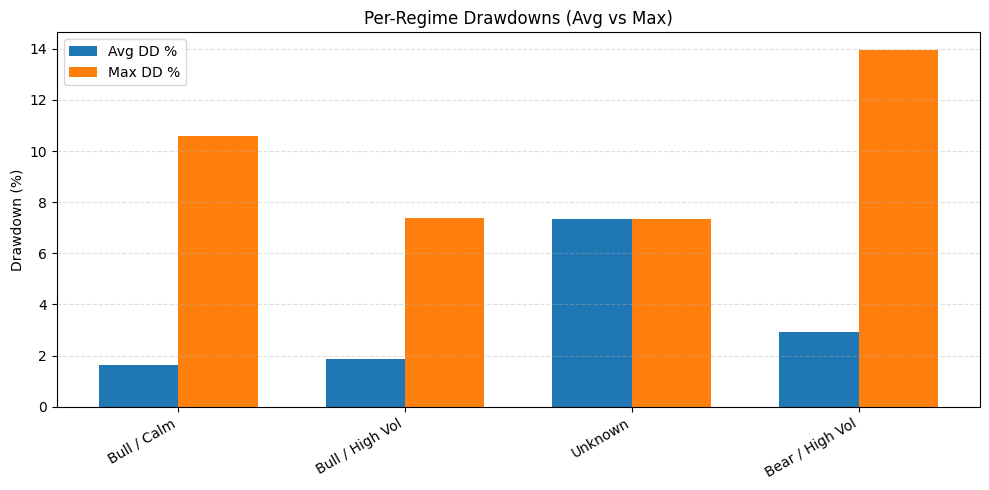

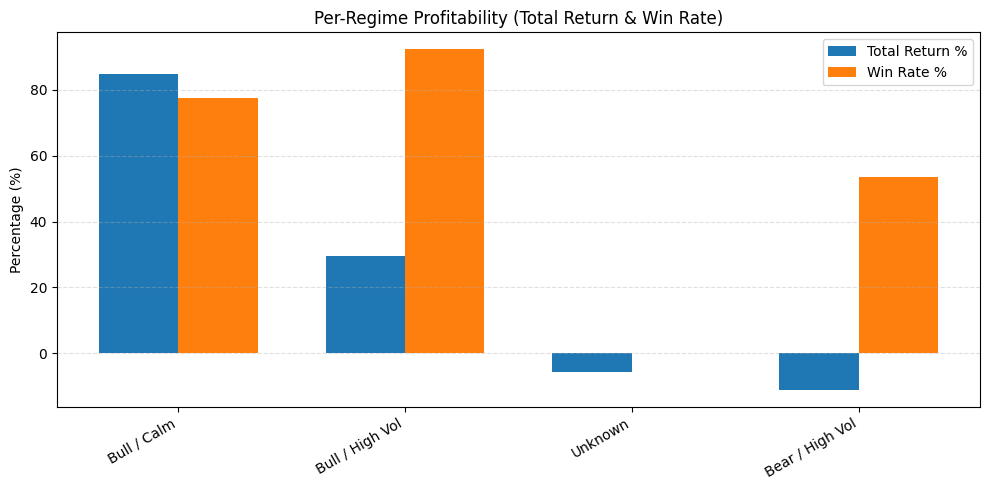

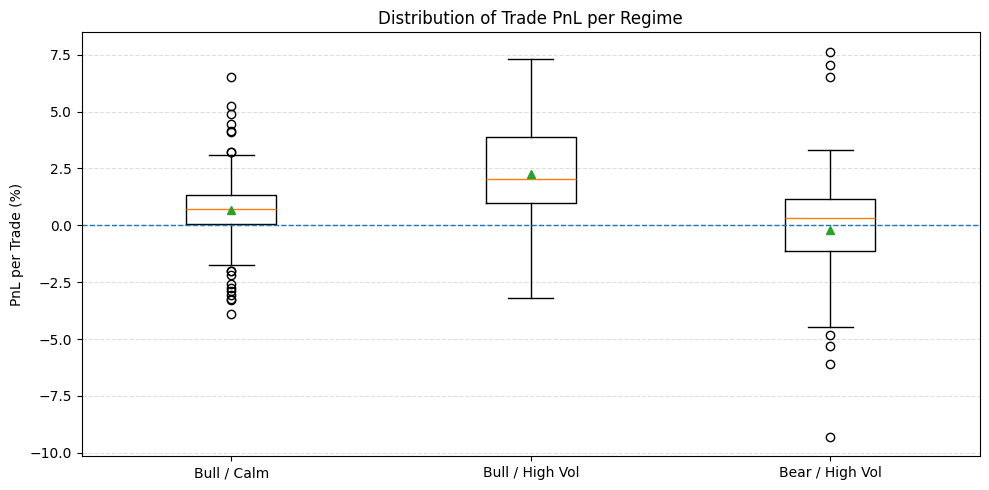

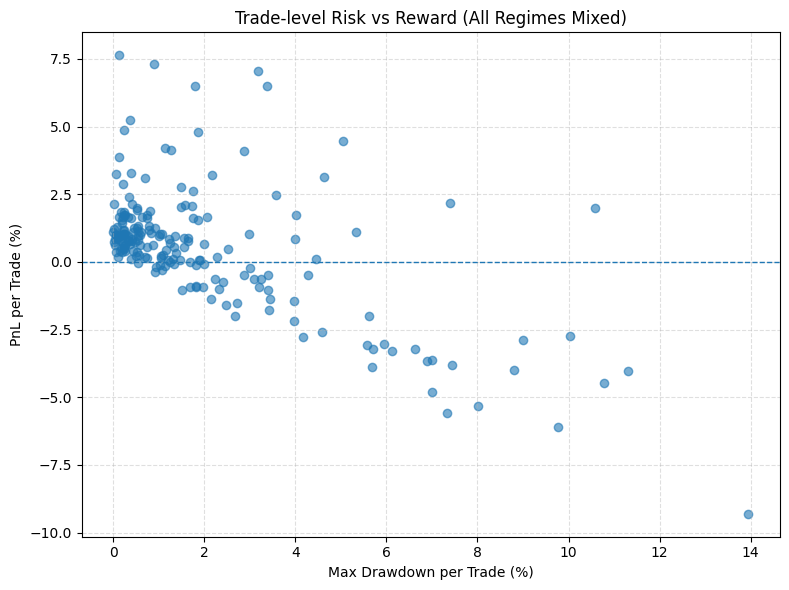

In [36]:
#===============================================================================
# CELL: Visualizing performance & drawdown per regime
#===============================================================================

import numpy as np
import matplotlib.pyplot as plt

# نتأكد إن عندنا بيانات ملخّصة per regime
print("\n=== Regime performance summary (regime_perf_df) ===")
print(regime_perf_df)

# نرتّبهم حسب أعلى Total Return
plot_df = regime_perf_df.sort_values("total_return_pct", ascending=False).reset_index(drop=True)
regimes = plot_df["regime_name"].values
x = np.arange(len(regimes))

#-------------------------------------------
# 1) Bar chart: Avg / Max Drawdown per Regime
#-------------------------------------------

fig, ax = plt.subplots(figsize=(10, 5))

width = 0.35
ax.bar(x - width/2, plot_df["avg_dd_pct"], width, label="Avg DD %")
ax.bar(x + width/2, plot_df["max_dd_pct"], width, label="Max DD %")

ax.set_xticks(x)
ax.set_xticklabels(regimes, rotation=30, ha="right")
ax.set_ylabel("Drawdown (%)")
ax.set_title("Per-Regime Drawdowns (Avg vs Max)")
ax.legend()
ax.grid(True, axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

#-------------------------------------------
# 2) Bar chart: Profit metrics per Regime
#    - Total Return %
#    - Win Rate %
#-------------------------------------------

fig, ax = plt.subplots(figsize=(10, 5))

width = 0.35
ax.bar(x - width/2, plot_df["total_return_pct"], width, label="Total Return %")
ax.bar(x + width/2, plot_df["win_rate_pct"], width, label="Win Rate %")

ax.set_xticks(x)
ax.set_xticklabels(regimes, rotation=30, ha="right")
ax.set_ylabel("Percentage (%)")
ax.set_title("Per-Regime Profitability (Total Return & Win Rate)")
ax.legend()
ax.grid(True, axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

#-------------------------------------------
# 3) Boxplot: توزيع PnL لكل صفقة في كل Regime
#-------------------------------------------

# هنشيل Unknown لأنها واحدة أو قليلة ومش مهمة أوي في الصورة الكبيرة
valid_trades = trades_with_regime.copy()
valid_trades = valid_trades[valid_trades["regime_name"].notna()]
valid_trades = valid_trades[valid_trades["regime_name"] != "Unknown"]

if not valid_trades.empty:
    # نضمن نفس ترتيب الregimes زي plot_df
    ordered_regimes = [r for r in regimes if r in valid_trades["regime_name"].unique()]
    data_per_regime = [
        valid_trades[valid_trades["regime_name"] == r]["pnl_pct"].values
        for r in ordered_regimes
    ]

    fig, ax = plt.subplots(figsize=(10, 5))

    bp = ax.boxplot(
        data_per_regime,
        labels=ordered_regimes,
        showmeans=True
    )

    ax.axhline(0, linestyle="--", linewidth=1)
    ax.set_ylabel("PnL per Trade (%)")
    ax.set_title("Distribution of Trade PnL per Regime")
    ax.grid(True, axis="y", linestyle="--", alpha=0.4)

    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ No valid trades with regime_name for boxplot.")

#-------------------------------------------
# 4) Scatter: لكل صفقة → العلاقة بين Max DD و PnL
#    (Risk vs Reward per trade)
#-------------------------------------------

if not trades_with_regime.empty:
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.scatter(
        trades_with_regime["max_dd_pct"],
        trades_with_regime["pnl_pct"],
        alpha=0.6
    )

    ax.axhline(0, linestyle="--", linewidth=1)
    ax.set_xlabel("Max Drawdown per Trade (%)")
    ax.set_ylabel("PnL per Trade (%)")
    ax.set_title("Trade-level Risk vs Reward (All Regimes Mixed)")
    ax.grid(True, linestyle="--", alpha=0.4)

    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ trades_with_regime is empty – no trades to plot.")


In [37]:
#===============================================================================
# CELL: Detailed stats for the *current* regime (Bear / High Vol now)
#===============================================================================

import numpy as np

# نعيد حساب آخر window عشان نبقى متأكدين
if regime_df is None or regime_df.empty:
    print("⚠️ regime_df is empty. Run the regime clustering cell first.")
else:
    last_win = regime_df.sort_values("end_time").iloc[-1]
    current_regime = last_win["regime_name"]
    current_cluster = int(last_win["cluster"])

    print("=== Current Regime (from last window) ===")
    print(f"  Start:   {last_win['start_time']}")
    print(f"  End:     {last_win['end_time']}")
    print(f"  Cluster: {current_cluster}")
    print(f"  Regime:  {current_regime}")

    #-----------------------------
    # 1) فلتر كل الصفقات في نفس الـ regime
    #-----------------------------
    cur_trades = trades_with_regime[
        trades_with_regime["regime_name"] == current_regime
    ].copy()

    if cur_trades.empty:
        print(f"\n⚠️ No trades found in regime '{current_regime}'.")
    else:
        print(f"\nFound {len(cur_trades)} trades in regime '{current_regime}'.")

        #-----------------------------
        # 2) PnL overview
        #-----------------------------
        win_mask = cur_trades["pnl_pct"] > 0
        lose_mask = cur_trades["pnl_pct"] <= 0

        n_trades = len(cur_trades)
        n_wins   = win_mask.sum()
        n_losses = lose_mask.sum()

        win_rate = n_wins / n_trades * 100.0
        avg_pnl  = cur_trades["pnl_pct"].mean()
        median_pnl = cur_trades["pnl_pct"].median()
        worst_loss = cur_trades["pnl_pct"].min()
        best_win   = cur_trades["pnl_pct"].max()
        total_ret  = cur_trades["pnl_pct"].sum()

        print("\n=== PnL STATS (current regime only) ===")
        print(f"  #Trades:         {n_trades}")
        print(f"  Wins / Losses:   {n_wins} / {n_losses}")
        print(f"  Win Rate:        {win_rate:.2f}%")
        print(f"  Avg PnL/trade:   {avg_pnl:+.2f}%")
        print(f"  Median PnL:      {median_pnl:+.2f}%")
        print(f"  Best trade:      {best_win:+.2f}%")
        print(f"  Worst trade:     {worst_loss:+.2f}%")
        print(f"  Total Return:    {total_ret:+.2f}%")

        #-----------------------------
        # 3) Drawdown distribution (كل الصفقات)
        #-----------------------------
        dd_all = cur_trades["max_dd_pct"].values

        def safe_percentile(arr, q):
            return float(np.percentile(arr, q)) if len(arr) > 0 else 0.0

        dd_mean    = float(np.mean(dd_all))
        dd_median  = safe_percentile(dd_all, 50)
        dd_p75     = safe_percentile(dd_all, 75)
        dd_p90     = safe_percentile(dd_all, 90)
        dd_p95     = safe_percentile(dd_all, 95)
        dd_max     = float(np.max(dd_all))

        print("\n=== DRAWDOWN STATS (all trades, current regime) ===")
        print(f"  Mean DD:         {dd_mean:.2f}%")
        print(f"  Median DD:       {dd_median:.2f}%")
        print(f"  75th pct DD:     {dd_p75:.2f}%")
        print(f"  90th pct DD:     {dd_p90:.2f}%")
        print(f"  95th pct DD:     {dd_p95:.2f}%")
        print(f"  Worst DD (max):  {dd_max:.2f}%")

        #-----------------------------
        # 4) Drawdown conditional:
        #    - على الصفقات الكسبانة
        #    - على الصفقات الخسرانة
        #-----------------------------
        dd_wins = cur_trades.loc[win_mask, "max_dd_pct"].values
        dd_losses = cur_trades.loc[lose_mask, "max_dd_pct"].values

        if len(dd_wins) > 0:
            print("\n--- Drawdown on WINNING trades only ---")
            print(f"  Mean DD (wins):     {np.mean(dd_wins):.2f}%")
            print(f"  Median DD (wins):   {safe_percentile(dd_wins, 50):.2f}%")
            print(f"  75th pct DD (wins): {safe_percentile(dd_wins, 75):.2f}%")
            print(f"  90th pct DD (wins): {safe_percentile(dd_wins, 90):.2f}%")
        else:
            print("\n--- No winning trades in this regime to analyze DD for wins. ---")

        if len(dd_losses) > 0:
            print("\n--- Drawdown on LOSING trades only ---")
            print(f"  Mean DD (losses):     {np.mean(dd_losses):.2f}%")
            print(f"  Median DD (losses):   {safe_percentile(dd_losses, 50):.2f}%")
            print(f"  75th pct DD (losses): {safe_percentile(dd_losses, 75):.2f}%")
            print(f"  90th pct DD (losses): {safe_percentile(dd_losses, 90):.2f}%")
        else:
            print("\n--- No losing trades in this regime to analyze DD for losses. ---")

        #-----------------------------
        # 5) Holding time (bars_held)
        #-----------------------------
        bh = cur_trades["bars_held"].values
        bh_mean   = float(np.mean(bh))
        bh_median = safe_percentile(bh, 50)
        bh_p75    = safe_percentile(bh, 75)
        bh_p90    = safe_percentile(bh, 90)

        print("\n=== HOLDING TIME (bars_held, current regime) ===")
        print(f"  Mean bars held:   {bh_mean:.1f}")
        print(f"  Median bars held: {bh_median:.1f}")
        print(f"  75th pct:         {bh_p75:.1f}")
        print(f"  90th pct:         {bh_p90:.1f}")


=== Current Regime (from last window) ===
  Start:   2025-10-10 06:30:00-04:00
  End:     2025-11-10 10:45:00-05:00
  Cluster: 2
  Regime:  Bear / High Vol

Found 56 trades in regime 'Bear / High Vol'.

=== PnL STATS (current regime only) ===
  #Trades:         56
  Wins / Losses:   30 / 26
  Win Rate:        53.57%
  Avg PnL/trade:   -0.20%
  Median PnL:      +0.31%
  Best trade:      +7.64%
  Worst trade:     -9.31%
  Total Return:    -11.08%

=== DRAWDOWN STATS (all trades, current regime) ===
  Mean DD:         2.91%
  Median DD:       1.66%
  75th pct DD:     3.59%
  90th pct DD:     7.73%
  95th pct DD:     10.02%
  Worst DD (max):  13.95%

--- Drawdown on WINNING trades only ---
  Mean DD (wins):     1.04%
  Median DD (wins):   0.55%
  75th pct DD (wins): 1.42%
  90th pct DD (wins): 2.59%

--- Drawdown on LOSING trades only ---
  Mean DD (losses):     5.06%
  Median DD (losses):   3.78%
  75th pct DD (losses): 7.33%
  90th pct DD (losses): 10.27%

=== HOLDING TIME (bars_held, cu

In [38]:
#===============================================================================
# CELL: Signal Quality Map + Best Filters *inside current regime*
#===============================================================================

import numpy as np

#-----------------------------
# 0) Choose objective mode
#-----------------------------
# 1 = Default (avg_pnl - 0.3 * avg_dd)
# 2 = Total Return
# 3 = Only combos with win_rate >= 50%, sorted by avg_pnl
objective_mode = 1

# Minimum number of trades per combo to be considered
min_trades_per_combo = 10

#-----------------------------
# 1) Identify current regime again (from last window)
#-----------------------------
last_win = regime_df.sort_values("end_time").iloc[-1]
current_regime = last_win["regime_name"]
current_cluster = int(last_win["cluster"])

print("=== Current regime for Signal Quality Map ===")
print(f"  Start:   {last_win['start_time']}")
print(f"  End:     {last_win['end_time']}")
print(f"  Cluster: {current_cluster}")
print(f"  Regime:  {current_regime}")

#-----------------------------
# 2) Filter trades in this regime only
#-----------------------------
cur_trades = trades_with_regime[
    trades_with_regime["regime_name"] == current_regime
].copy()

print(f"\nTrades in current regime: {len(cur_trades)}")

rows = []
missing_entries = 0

for _, tr in cur_trades.iterrows():
    t = tr["entry_time"]

    # لو الـ index مش موجود بالضبط، نسيبه (أبسط حاجة)
    if t not in df_result.index:
        missing_entries += 1
        continue

    row = df_result.loc[t]

    rows.append({
        "entry_time": t,
        "pnl_pct": float(tr["pnl_pct"]),
        "max_dd_pct": float(tr["max_dd_pct"]),
        "bars_held": int(tr["bars_held"]),

        # features at entry:
        "pos_div_count": int(row.get("pos_div_count", 0)),
        "neg_div_count": int(row.get("neg_div_count", 0)),
        "rsi": float(row.get("rsi", np.nan)),
        "stoch": float(row.get("stoch", np.nan)),
        "macd_hist": float(row.get("macd_hist", np.nan)),
    })

sig_regime_df = pd.DataFrame(rows)

print(f"Built signal feature DF with {len(sig_regime_df)} rows (missing={missing_entries})")
if sig_regime_df.empty:
    raise ValueError("No matching entries between trades and df_result for current regime.")

print("\nSample of signal-regime features:")
print(sig_regime_df.head())

#-----------------------------
# 3) Build buckets (RSI / Stoch)
#-----------------------------

def rsi_bucket(r):
    if np.isnan(r):
        return "NA"
    if r < 30:  return "<30"
    if r < 40:  return "30-40"
    if r < 50:  return "40-50"
    if r < 60:  return "50-60"
    return ">=60"

def stoch_bucket(s):
    if np.isnan(s):
        return "NA"
    if s < 20:  return "<20"
    if s < 40:  return "20-40"
    if s < 60:  return "40-60"
    if s < 80:  return "60-80"
    return ">=80"

sig_regime_df["is_win"] = sig_regime_df["pnl_pct"] > 0
sig_regime_df["rsi_bucket"] = sig_regime_df["rsi"].apply(rsi_bucket)
sig_regime_df["stoch_bucket"] = sig_regime_df["stoch"].apply(stoch_bucket)

#-----------------------------
# 4) Group by (pos_div_count, rsi_bucket, stoch_bucket)
#-----------------------------

group_cols = ["pos_div_count", "rsi_bucket", "stoch_bucket"]

combo_stats = (
    sig_regime_df
    .groupby(group_cols)
    .agg(
        n_trades=("pnl_pct", "count"),
        win_rate=("is_win", "mean"),
        avg_pnl=("pnl_pct", "mean"),
        median_pnl=("pnl_pct", "median"),
        avg_dd=("max_dd_pct", "mean"),
        median_dd=("max_dd_pct", "median"),
        total_return=("pnl_pct", "sum"),
    )
    .reset_index()
)

combo_stats["win_rate"] = combo_stats["win_rate"] * 100.0
combo_stats["total_return_pct"] = combo_stats["total_return"]

# Filter combos with enough trades
combo_stats = combo_stats[combo_stats["n_trades"] >= min_trades_per_combo].copy()

if combo_stats.empty:
    print(f"\n⚠️ No combos with at least {min_trades_per_combo} trades.")
else:
    #-----------------------------
    # 5) Define objective score
    #-----------------------------
    if objective_mode == 1:
        # Default: profit - 0.3 * DD
        combo_stats["score"] = combo_stats["avg_pnl"] - 0.3 * combo_stats["avg_dd"]
        objective_name = "score = avg_pnl - 0.3 * avg_dd"
    elif objective_mode == 2:
        combo_stats["score"] = combo_stats["total_return_pct"]
        objective_name = "score = total_return_pct"
    else:
        # mode 3: only combos with win_rate >= 50%, score = avg_pnl
        combo_stats = combo_stats[combo_stats["win_rate"] >= 50.0].copy()
        combo_stats["score"] = combo_stats["avg_pnl"]
        objective_name = "score = avg_pnl (win_rate >= 50% only)"

    # Sort by score desc
    combo_stats_sorted = combo_stats.sort_values("score", ascending=False).reset_index(drop=True)

    print("\n===============================================")
    print(f"🏆 TOP SIGNAL COMBOS inside regime = '{current_regime}'")
    print(f"Objective: {objective_name}")
    print("===============================================\n")

    # Show top 15
    print(combo_stats_sorted.head(15))

    # # لو حابب تحفظها CSV
    out_name = f"signal_quality_combos_current_regime.replace(' ','_').csv"
    combo_stats_sorted.to_csv(out_name, index=False)
    print(f"\n📁 Full combo table saved to: {out_name}")


=== Current regime for Signal Quality Map ===
  Start:   2025-10-10 06:30:00-04:00
  End:     2025-11-10 10:45:00-05:00
  Cluster: 2
  Regime:  Bear / High Vol

Trades in current regime: 56
Built signal feature DF with 56 rows (missing=0)

Sample of signal-regime features:
                  entry_time   pnl_pct  max_dd_pct  bars_held  pos_div_count  \
0  2024-01-05 13:00:00-05:00  1.242329    0.452256          8              0   
1  2024-01-07 22:45:00-05:00  7.636559    0.137772         49              0   
2  2024-01-12 09:15:00-05:00 -6.082847    9.768237        103              0   
3  2024-01-17 13:00:00-05:00  1.164824    0.243065         19              0   
4  2024-01-18 13:00:00-05:00 -1.522221    2.727084         19              0   

   neg_div_count        rsi      stoch   macd_hist  
0              0  45.798374  43.996664  -41.343567  
1              0  32.064445  27.210848  -74.717007  
2              0  26.594994  31.061753  -30.417926  
3              0  44.494518  28.2

In [ ]:
#===============================================================================
# CELL: Regime-Conditioned AI Stress Test (Gaussian Mixture Scenarios)
#  - Uses current regime (e.g. Bear / High Vol)
#  - Fits Gaussian Mixture on log-returns inside this regime
#  - Generates synthetic future price paths
#  - Runs your divergence strategy on each path
#  - Prints rich stats + saves CSV with all scenario metrics
#===============================================================================

from sklearn.mixture import GaussianMixture
import numpy as np
import pandas as pd

#-----------------------------
# 0) Config for stress test
#-----------------------------
n_scenarios   = 200   # عدد السيناريوهات synthetic
horizon_bars  = 200   # طول كل سيناريو (عدد الشموع قدّام)
n_components  = 3     # عدد مكونات Gaussian Mixture
random_state  = 42

print("=== Regime-Conditioned Stress Test (AI / Gaussian Mixture) ===")

#-----------------------------
# 1) Identify current regime again (from regime_df)
#-----------------------------
last_win = regime_df.sort_values("end_time").iloc[-1]
current_regime  = last_win["regime_name"]
current_cluster = int(last_win["cluster"])

print(f"\nCurrent regime:")
print(f"  Start window: {last_win['start_time']}")
print(f"  End window:   {last_win['end_time']}")
print(f"  Cluster:      {current_cluster}")
print(f"  Regime name:  {current_regime}")

#-----------------------------
# 2) Load base price data (for returns + volume templates)
#-----------------------------
base_df = load_data_from_csv(csv_filename).copy()
base_df["log_ret"] = np.log(base_df["close"]).diff()

print(f"\nBase DF has {len(base_df)} bars, log_ret available from index 1..N.")

#-----------------------------
# 3) Collect training returns for ALL windows that share same cluster
#-----------------------------
same_regime_windows = regime_df[regime_df["cluster"] == current_cluster].copy()
print(f"\nNumber of windows in same cluster (training regime): {len(same_regime_windows)}")

idx_list = []
for _, row in same_regime_windows.iterrows():
    start_idx = int(row["start_idx"])
    end_idx   = int(row["end_idx"])
    # log_ret محسوبة من diff، فبنستخدم من start_idx+1 لحد end_idx
    idx_list.extend(range(start_idx + 1, end_idx + 1))

idx_list = sorted(set(idx_list))
idx_list = [i for i in idx_list if 0 <= i < len(base_df)]

train_rets = base_df["log_ret"].iloc[idx_list].dropna()
train_vols = base_df["volume"].iloc[idx_list].dropna()

if len(train_rets) < 100:
    raise ValueError(f"Too few returns in training regime sample: {len(train_rets)}")

print(f"Training sample size (log_ret in this regime): {len(train_rets)}")

#-----------------------------
# 4) Basic stats on training returns (for info)
#-----------------------------
ret_stats = {
    "mean":      train_rets.mean(),
    "std":       train_rets.std(),
    "min":       train_rets.min(),
    "max":       train_rets.max(),
    "p05":       train_rets.quantile(0.05),
    "p50":       train_rets.quantile(0.50),
    "p95":       train_rets.quantile(0.95),
}
print("\n=== Training returns stats (current regime) ===")
for k, v in ret_stats.items():
    print(f"  {k:>4s}: {v:+.5f}")

#-----------------------------
# 5) Fit Gaussian Mixture Model on 1D log-return
#-----------------------------
X = train_rets.values.reshape(-1, 1)
gmm = GaussianMixture(
    n_components=n_components,
    covariance_type="full",
    random_state=random_state
)
gmm.fit(X)

print(f"\nFitted GaussianMixture with {n_components} components on regime returns.")
print("Component weights:", np.round(gmm.weights_, 3))
print("Component means:  ", np.round(gmm.means_.flatten(), 5))

#-----------------------------
# Helper: build synthetic OHLC from sampled log-returns
#-----------------------------
def build_ohlc_from_returns(last_close, log_rets, volume_template):
    """
    - last_close: آخر سعر حقيقي (نبدأ منه)
    - log_rets:   array of log-returns to apply
    - volume_template: series/array to sample volumes from
    """
    n = len(log_rets)

    opens  = np.zeros(n)
    highs  = np.zeros(n)
    lows   = np.zeros(n)
    closes = np.zeros(n)

    price = float(last_close)

    for i in range(n):
        opens[i] = price
        # نطبّق الـ log-return على السعر
        price = price * np.exp(log_rets[i])
        closes[i] = price

        # نعمل high/low صناعيين based on magnitude of move
        mag = max(0.0005, abs(log_rets[i]))  # كل ما الـ move أكبر، ال range يكبر
        up_factor = np.exp(mag * 0.7)   # 70% من الماجنتود
        dn_factor = np.exp(-mag * 0.7)

        highs[i] = closes[i] * up_factor
        lows[i]  = closes[i] * dn_factor

        # تأكد low <= open/close <= high
        low_i  = min(lows[i], opens[i], closes[i])
        high_i = max(highs[i], opens[i], closes[i])
        lows[i]  = low_i
        highs[i] = high_i

    # نعيّن volume من العينة الحقيقية في نفس الريجيم
    if len(volume_template) == 0:
        vols = np.full(n, 1_000_000)
    else:
        vols = np.random.choice(volume_template, size=n)

    # نعمل index صناعي (مش مهم التوقيت الحقيقي هنا)
    # بدل inferred_freq property نستخدم pd.infer_freq
    try:
        freq_guess = pd.infer_freq(base_df.index)
    except ValueError:
        freq_guess = None

    if freq_guess is None:
        # fallback: فرض إن الفريم 45 دقيقة لو مفيش freq
        freq_guess = "45min"

    start_time = base_df.index[-1] + pd.tseries.frequencies.to_offset(freq_guess)
    idx = pd.date_range(start=start_time, periods=n, freq=freq_guess)

    scen_df = pd.DataFrame({
        "open": opens,
        "high": highs,
        "low":  lows,
        "close": closes,
        "volume": vols,
    }, index=idx)

    return scen_df

#-----------------------------
# Helper: quick performance on a scenario
#-----------------------------
def scenario_quick_performance(df):
    """
    نسخة مختصرة من performance:
      - total_trades, win_rate, avg_pnl, total_return
      - max_dd, avg_dd, median_dd
    """
    entries = df[df["signal"] == 1].copy()
    exits   = df[df["signal"] == -1].copy()

    if len(entries) == 0:
        return {
            "total_trades": 0,
            "win_rate": 0.0,
            "avg_pnl": 0.0,
            "total_return_pct": 0.0,
            "max_dd": 0.0,
            "avg_dd": 0.0,
            "median_dd": 0.0,
        }

    pnl_list = []
    dd_list  = []

    for _, entry_row in entries.iterrows():
        entry_time  = entry_row.name
        entry_idx   = df.index.get_loc(entry_time)
        entry_price = float(entry_row["entry_price"])

        # أول exit بعد الـ entry
        candidate_exits = exits[exits.index > entry_time]
        if len(candidate_exits) == 0:
            exit_idx   = len(df) - 1
            exit_price = float(df["close"].iloc[-1])
        else:
            first_exit = candidate_exits.iloc[0]
            exit_idx   = df.index.get_loc(first_exit.name)
            exit_price = float(first_exit["exit_price"])

        pnl_pct = (exit_price - entry_price) / entry_price * 100.0
        pnl_list.append(pnl_pct)

        # Drawdown جوه الصفقة على أساس الـ low
        trade_slice = df.iloc[entry_idx:exit_idx + 1]
        dd_series   = (trade_slice["low"] - entry_price) / entry_price * 100.0
        worst_dd    = dd_series.min()    # negative
        dd_mag      = abs(worst_dd)
        dd_list.append(dd_mag)

    pnl_arr = np.array(pnl_list)
    dd_arr  = np.array(dd_list)

    total_trades = len(pnl_arr)
    wins         = (pnl_arr > 0).sum()
    win_rate     = (wins / total_trades * 100.0) if total_trades > 0 else 0.0
    avg_pnl      = pnl_arr.mean() if total_trades > 0 else 0.0
    total_return = pnl_arr.sum()

    max_dd    = dd_arr.max()   if len(dd_arr) > 0 else 0.0
    avg_dd    = dd_arr.mean()  if len(dd_arr) > 0 else 0.0
    median_dd = np.median(dd_arr) if len(dd_arr) > 0 else 0.0

    return {
        "total_trades": int(total_trades),
        "win_rate": float(win_rate),
        "avg_pnl": float(avg_pnl),
        "total_return_pct": float(total_return),
        "max_dd": float(max_dd),
        "avg_dd": float(avg_dd),
        "median_dd": float(median_dd),
    }

#-----------------------------
# 6) Run scenarios
#-----------------------------
last_close_real = float(base_df["close"].iloc[-1])
volume_template = train_vols.values

scenario_results = []

print(f"\nGenerating {n_scenarios} synthetic scenarios "
      f"of length {horizon_bars} bars from regime '{current_regime}'...")

for s in range(1, n_scenarios + 1):
    # 6.1 sample log-returns from GMM
    sampled_rets, _ = gmm.sample(horizon_bars)
    sampled_rets = sampled_rets.flatten()

    # 6.2 build synthetic OHLC
    scen_df = build_ohlc_from_returns(last_close_real, sampled_rets, volume_template)

    # 6.3 run full pipeline: indicators + pivots + divergences + strategy
    scen_df = calculate_indicators(scen_df)
    scen_df = find_pivots(scen_df, config.prd)
    scen_df = scan_all_divergences(scen_df)
    scen_df = run_strategy(scen_df)

    metrics = scenario_quick_performance(scen_df)
    metrics["scenario_id"] = s

    scenario_results.append(metrics)

    if s % 20 == 0 or s == n_scenarios:
        print(f"  -> scenario {s}/{n_scenarios} done "
              f"(trades={metrics['total_trades']}, "
              f"total_return={metrics['total_return_pct']:.2f}%, "
              f"max_dd={metrics['max_dd']:.2f}%)")

#-----------------------------
# 7) Aggregate and print rich stats
#-----------------------------
scen_df_metrics = pd.DataFrame(scenario_results)

print("\n===============================================")
print(f"📊 STRESS TEST SUMMARY for regime = '{current_regime}'")
print("===============================================")

print(f"Total scenarios: {len(scen_df_metrics)}")
print("Scenarios with at least 1 trade:",
      int((scen_df_metrics['total_trades'] > 0).sum()))

print("\n→ Distribution of total_return_pct:")
for q in [0.05, 0.25, 0.50, 0.75, 0.95]:
    val = scen_df_metrics["total_return_pct"].quantile(q)
    print(f"  {int(q*100):2d}th percentile: {val:+.2f}%")

print("\n→ Distribution of max_dd:")
for q in [0.50, 0.75, 0.90, 0.95]:
    val = scen_df_metrics["max_dd"].quantile(q)
    print(f"  {int(q*100):2d}th percentile DD: {val:.2f}%")

# Worst & Best scenarios
print("\n=== Worst 5 scenarios by total_return_pct ===")
print(
    scen_df_metrics
    .nsmallest(5, "total_return_pct")
    [["scenario_id", "total_trades", "win_rate",
      "total_return_pct", "max_dd", "avg_dd", "median_dd"]]
)

print("\n=== Best 5 scenarios by total_return_pct ===")
print(
    scen_df_metrics
    .nlargest(5, "total_return_pct")
    [["scenario_id", "total_trades", "win_rate",
      "total_return_pct", "max_dd", "avg_dd", "median_dd"]]
)

# Probability of very bad drawdown / loss
loss_prob_0 = (scen_df_metrics["total_return_pct"] < 0).mean() * 100.0
loss_prob_10 = (scen_df_metrics["total_return_pct"] <= -10).mean() * 100.0
dd_prob_15 = (scen_df_metrics["max_dd"] >= 15).mean() * 100.0

print("\n→ Tail risk estimates (across scenarios):")
print(f"  P(total_return_pct < 0%)   ≈ {loss_prob_0:.1f}%")
print(f"  P(total_return_pct ≤ -10%) ≈ {loss_prob_10:.1f}%")
print(f"  P(max_dd ≥ 15%)            ≈ {dd_prob_15:.1f}%")

#-----------------------------
# 8) Save full scenario metrics to CSV
#-----------------------------
out_csv_name = f"regime_stress_test_scenarios_current_regime.replace(' ','_').csv"
scen_df_metrics.to_csv(out_csv_name, index=False)
print(f"\n📁 Saved full scenario metrics to: {out_csv_name}")

print("\nDone ✅ - You now have a distribution of possible futures in this regime.")


=== Regime-Conditioned Stress Test (AI / Gaussian Mixture) ===

Current regime:
  Start window: 2025-10-10 06:30:00-04:00
  End window:   2025-11-10 10:45:00-05:00
  Cluster:      2
  Regime name:  Bear / High Vol
Loading data from BTC-45-Prices.csv...
Loaded 21901 bars from 2023-12-31 19:00:00-05:00 to 2025-11-15 04:00:00-05:00

Base DF has 21901 bars, log_ret available from index 1..N.

Number of windows in same cluster (training regime): 21
Training sample size (log_ret in this regime): 12500

=== Training returns stats (current regime) ===
  mean: -0.00008
   std: +0.00462
   min: -0.06976
   max: +0.06364
   p05: -0.00664
   p50: -0.00003
   p95: +0.00628

Fitted GaussianMixture with 3 components on regime returns.
Component weights: [0.072 0.098 0.83 ]
Component means:   [-5.37e-03  3.39e-03 -4.00e-05]

Generating 200 synthetic scenarios of length 200 bars from regime 'Bear / High Vol'...
Calculating indicators...
Indicators calculated successfully
Finding pivot points with perio